In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import statsmodels as st
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch.utils.data as data_utils

In [2]:
data = pd.read_csv('./final_outer.csv', index_col=0)
data['crime'] = data['Rate per 100,000 population']
data = data.drop(columns=['Rate per 100,000 population'])

def normalize(col):
    col = ''.join(col.split())
    col = ''.join(e for e in col if e.isalnum())
    out: str = col.replace(',','_').lower()
    if out[0].isdigit():
        out = '_' + out
    return out

data.rename(columns=normalize, inplace=True)
data.describe()

,year,egm,medianhouseprice,offencecount,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,presentationstoemergencydepartments201213,traveltimetonearestpublichospitalwithemergencydepartment,presentationstoemergencydepartmentsduetoinjury,category45emergencydepartmentpresentations,numberofdwellings,population,locationx,locationy,absremotenesscategory,crime
count,570.000000,5.700000e+02,4.480000e+02,399.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,399.000000
mean,2015.500000,4.475087e+07,6.730241e+05,8711.486216,89.606698,2385.559871,0.651840,0.924022,0.776669,0.015653,...,0.275168,25.493637,0.248753,0.567736,40334.421053,99988.000000,-3.804322,24.600444,0.596491,8621.666757
std,2.874804,3.654833e+07,4.536039e+05,6814.604619,90.258987,4359.046867,0.923016,1.239729,1.069332,0.024118,...,0.120782,23.096960,0.039089,0.076362,24869.081733,67492.921038,106.181404,83.253195,0.697967,3480.497806
min,2011.000000,1.892293e+06,1.512500e+05,387.000000,4.897709,20.822930,0.000000,0.000000,0.000000,0.000052,...,0.050232,3.930699,0.140255,0.399250,4874.000000,9873.000000,-310.285714,-85.083283,0.000000,3076.800763
25%,2013.000000,1.236583e+07,3.380238e+05,3055.500000,20.289781,65.887204,0.000000,0.000000,0.000000,0.000369,...,0.183279,8.628051,0.218941,0.514380,18187.000000,38580.000000,-24.132895,-19.991837,0.000000,6502.077166
50%,2015.500000,3.027379e+07,5.515666e+05,7867.000000,53.726582,654.711013,0.068634,0.224843,0.130797,0.002820,...,0.253923,15.863108,0.256337,0.567464,38495.000000,92508.000000,4.894320,0.923112,0.000000,8254.364090
75%,2018.000000,7.021907e+07,8.867353e+05,12282.000000,135.640780,3198.489793,1.213264,1.483585,1.385136,0.023797,...,0.384497,33.194080,0.278660,0.614959,59303.000000,150781.000000,27.153846,38.319368,1.000000,10225.841252
max,2020.000000,1.456191e+08,2.841161e+06,37886.000000,384.960766,23359.313312,3.272194,4.383425,3.737190,0.127473,...,0.553260,96.843507,0.322547,0.725373,107828.000000,298909.000000,274.239407,343.714443,2.000000,25932.263717


In [3]:
actual = data[data['year'].isin(list(range(2016, 2021)))]
actual = actual.copy()

# insert last year
for i, row in actual.iterrows():
    last = data[(data['year'] == row['year']-1) & (data['lga'] == row['lga'])].copy()
    distance = np.sqrt(row['locationx'] ** 2 + row['locationy'] ** 2)
    actual.loc[i, 'distance'] = distance
    last_2 = data[(data['year'] == row['year']-2) & (data['lga'] == row['lga'])].copy()
    last_3 = data[(data['year'] == row['year']-3) & (data['lga'] == row['lga'])].copy()
    last_4 = data[(data['year'] == row['year']-4) & (data['lga'] == row['lga'])].copy()
    last_5 = data[(data['year'] == row['year']-5) & (data['lga'] == row['lga'])].copy()
    actual.loc[i, 'last_crime'] = last['crime'].values[0]
    actual.loc[i, 'last2_crime'] = last_2['crime'].values[0]
    actual.loc[i, 'last_house'] = last['medianhouseprice'].values[0]
    actual.loc[i, 'last2_house'] = last_2['medianhouseprice'].values[0]
    actual.loc[i, 'last3_house'] = last_3['medianhouseprice'].values[0]
    actual.loc[i, 'last_egm'] = last['egm'].values[0]
    actual.loc[i, 'last2_egm'] = last_2['egm'].values[0]
    actual.loc[i, 'last3_egm'] = last_3['egm'].values[0]
    actual.loc[i, 'last4_egm'] = last_4['egm'].values[0]
    actual.loc[i, 'last5_egm'] = last_5['egm'].values[0]
    
actual = actual.dropna(axis=0)

actual = actual.reset_index(drop=True)
actual = actual.drop(columns=['offencecount'], axis=1)
cr = actual.pop('crime')
actual.insert(actual.shape[1], "crime", cr)
actual

,lga,year,egm,medianhouseprice,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,last3_egm,last4_egm,last5_egm,crime
0,whittlesea,2016,1.116516e+08,4.338032e+05,34.862554,590.075860,0.007974,0.056596,0.022594,0.005186,...,7233.141209,3.864022e+05,3.567570e+05,3.452792e+05,1.091612e+08,1.035006e+08,1.010001e+08,1.115836e+08,1.095429e+08,8048.952467
1,northerngrampians,2016,9.050693e+06,1.597500e+05,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,...,7947.694659,1.590000e+05,1.587500e+05,1.512500e+05,1.003788e+07,1.035065e+07,1.014142e+07,1.121941e+07,1.071793e+07,11633.535004
2,greatergeelong,2016,1.132050e+08,4.470595e+05,61.820207,1389.430557,0.152898,0.224843,0.182097,0.002401,...,8127.107630,4.230712e+05,4.084374e+05,3.872893e+05,1.130210e+08,1.116281e+08,1.097196e+08,1.183161e+08,1.184686e+08,9586.313140
3,colacotway,2016,1.016289e+07,4.342500e+05,137.416278,3232.099823,1.273625,1.806754,1.531375,0.000364,...,7259.476598,3.823333e+05,3.684167e+05,3.546667e+05,1.026330e+07,1.007489e+07,1.019461e+07,1.091608e+07,1.105642e+07,9343.694411
4,moorabool,2016,1.061337e+07,3.656250e+05,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,...,6183.609090,3.560000e+05,3.395000e+05,3.336250e+05,1.057564e+07,1.030988e+07,1.054645e+07,1.116534e+07,1.083741e+07,7755.876592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,maribyrnong,2020,4.224321e+07,8.882343e+05,11.629266,31.347530,0.000000,0.000000,0.000000,0.068430,...,9490.159895,8.490697e+05,9.238878e+05,9.075850e+05,5.725792e+07,5.492496e+07,5.406851e+07,5.373503e+07,5.299402e+07,10239.549084
276,stonnington,2020,1.411828e+07,2.841161e+06,9.937739,23.986985,0.000000,0.000000,0.000000,0.066525,...,9512.969825,2.535312e+06,2.594971e+06,2.651331e+06,1.986235e+07,2.085283e+07,2.303256e+07,2.344328e+07,2.301997e+07,10291.270757
277,gleneira,2020,5.402530e+07,1.516358e+06,15.409791,41.586761,0.000000,0.000000,0.000000,0.032422,...,4245.713273,1.430137e+06,1.466053e+06,1.520393e+06,7.424468e+07,7.717147e+07,7.625982e+07,7.621435e+07,7.355592e+07,5086.773226
278,bayside,2020,1.022713e+07,1.744736e+06,20.118347,35.882194,0.000000,0.000000,0.000000,0.023797,...,4478.938665,1.572118e+06,1.672062e+06,1.732025e+06,1.380787e+07,1.537867e+07,1.471008e+07,1.361502e+07,1.581324e+07,5319.088156


In [4]:
# one hot encode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


encoder = OneHotEncoder()
encoded = actual.copy()
encoded = encoded.drop(columns=['egm', 'medianhouseprice'], axis=1)
# encoded = encoded[[
#     'lga',
#     'last_crime',
#     'last2_crime',
#     'locationx',
#     'locationy',
#     'distance',
#     # check if it is correlated with region
#     'last_egm', 
#     'last2_egm', 
#     'last3_egm', 
#     'last_house', 
#     'last2_house', 
#     'crime'
#   ]]

new_ = encoded.select_dtypes(include=[np.number])

idx = new_.columns.get_loc('crime')
print(idx)
# year_idx = new_.columns.get_loc('year')
# print(year_idx)
last_idx = new_.columns.get_loc('last_crime')

# scaler = MinMaxScaler(feature_range=(0,1))
# new_[new_.columns] = scaler.fit_transform(new_[new_.columns])
# standardize all

out = encoder.fit_transform(encoded[['lga']])
lga = pd.DataFrame(out.toarray())
lga.rename(columns=lambda c: f"lga{c}", inplace=True)


new = pd.concat([lga, new_], axis=1)
# new['crime'] /= 20000
new

91


,lga0,lga1,lga2,lga3,lga4,lga5,lga6,lga7,lga8,lga9,...,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,last3_egm,last4_egm,last5_egm,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7233.141209,3.864022e+05,3.567570e+05,3.452792e+05,1.091612e+08,1.035006e+08,1.010001e+08,1.115836e+08,1.095429e+08,8048.952467
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7947.694659,1.590000e+05,1.587500e+05,1.512500e+05,1.003788e+07,1.035065e+07,1.014142e+07,1.121941e+07,1.071793e+07,11633.535004
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8127.107630,4.230712e+05,4.084374e+05,3.872893e+05,1.130210e+08,1.116281e+08,1.097196e+08,1.183161e+08,1.184686e+08,9586.313140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7259.476598,3.823333e+05,3.684167e+05,3.546667e+05,1.026330e+07,1.007489e+07,1.019461e+07,1.091608e+07,1.105642e+07,9343.694411
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6183.609090,3.560000e+05,3.395000e+05,3.336250e+05,1.057564e+07,1.030988e+07,1.054645e+07,1.116534e+07,1.083741e+07,7755.876592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9490.159895,8.490697e+05,9.238878e+05,9.075850e+05,5.725792e+07,5.492496e+07,5.406851e+07,5.373503e+07,5.299402e+07,10239.549084
276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9512.969825,2.535312e+06,2.594971e+06,2.651331e+06,1.986235e+07,2.085283e+07,2.303256e+07,2.344328e+07,2.301997e+07,10291.270757
277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4245.713273,1.430137e+06,1.466053e+06,1.520393e+06,7.424468e+07,7.717147e+07,7.625982e+07,7.621435e+07,7.355592e+07,5086.773226
278,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4478.938665,1.572118e+06,1.672062e+06,1.732025e+06,1.380787e+07,1.537867e+07,1.471008e+07,1.361502e+07,1.581324e+07,5319.088156


In [1377]:
print(lga.columns)

Index(['lga0', 'lga1', 'lga2', 'lga3', 'lga4', 'lga5', 'lga6', 'lga7', 'lga8',
       'lga9', 'lga10', 'lga11', 'lga12', 'lga13', 'lga14', 'lga15', 'lga16',
       'lga17', 'lga18', 'lga19', 'lga20', 'lga21', 'lga22', 'lga23', 'lga24',
       'lga25', 'lga26', 'lga27', 'lga28', 'lga29', 'lga30', 'lga31', 'lga32',
       'lga33', 'lga34', 'lga35', 'lga36', 'lga37', 'lga38', 'lga39', 'lga40',
       'lga41', 'lga42', 'lga43', 'lga44', 'lga45', 'lga46', 'lga47', 'lga48',
       'lga49', 'lga50', 'lga51', 'lga52', 'lga53', 'lga54', 'lga55'],
      dtype='object')


In [1355]:
# ml model


# one hot encode

state = 67458
train_data: pd.DataFrame = new.sample(frac=0.7, random_state=state)
test_data = new.drop(train_data.index)

scaler_x = MinMaxScaler(feature_range=(0,1))
# scaler_y = MinMaxScaler(feature_range=(0,1))

train_y = train_data['crime'].values
train_x = train_data.drop('crime', axis=1).values
test_y = test_data['crime'].values
test_x = test_data.drop('crime', axis=1).values


scaler_x.fit(train_x)
# scaler_y.fit(train_y.reshape(-1, 1))

train_x = scaler_x.transform(train_x)
# train_y = scaler_y.transform(train_y.reshape(-1, 1))
train_y = train_y


test_y = test_y
# test_y = scaler_y.transform(test_y.reshape(-1, 1))
test_x = scaler_x.transform(test_x)

print(train_x.shape, train_y.shape)

batch_size = 1

train = data_utils.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

# Create data loaders.
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(X)
    print(y)
    # print(f"Shape of X [N, C, H, W]: {X.shape}")
    # print(f"Shape of y: {y.shape} {y.dtype}")
    break


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

(196, 147) (196,)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3261e-02, 1.3557e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.2168e-01, 0.0000e+00, 9.0599e-01, 0.0000e+00,
         1.6109e-01, 3.0094e-01, 3.0561e-01, 0.0000e+00, 7.3805e-01, 1.7203e-02,
         0

In [1356]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 10 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    # print(f"Avg loss: {test_loss:>8f} \n")


mse_null 1187.5543436247672 test 2560.84, train 3632.65
mse_null 1187.5543436247672 test 2487.01, train 3432.20
mse_null 1187.5543436247672 test 2376.50, train 3237.79
mse_null 1187.5543436247672 test 2146.13, train 3030.53
mse_null 1187.5543436247672 test 1996.73, train 2782.00
mse_null 1187.5543436247672 test 2049.56, train 2565.29
mse_null 1187.5543436247672 test 1803.62, train 2262.98
mse_null 1187.5543436247672 test 1568.07, train 2052.42
mse_null 1187.5543436247672 test 1505.02, train 1796.23
mse_null 1187.5543436247672 test 1656.90, train 1684.08
mse_null 1187.5543436247672 test 1398.56, train 1536.18
mse_null 1187.5543436247672 test 1454.21, train 1377.29
mse_null 1187.5543436247672 test 1389.41, train 1291.40
mse_null 1187.5543436247672 test 1363.12, train 1225.52
mse_null 1187.5543436247672 test 1366.74, train 1170.09
mse_null 1187.5543436247672 test 1358.44, train 1124.38
mse_null 1187.5543436247672 test 1308.07, train 1090.47
mse_null 1187.5543436247672 test 1421.05, train 

KeyboardInterrupt: 

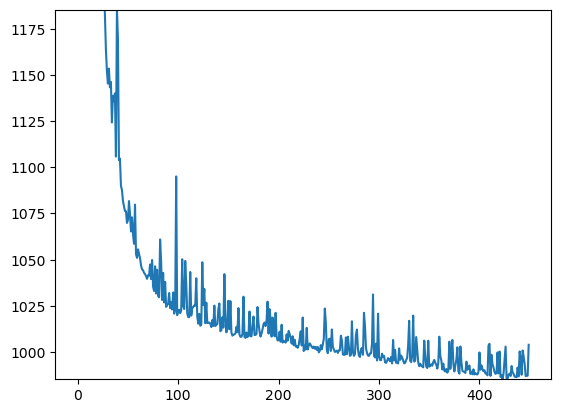

In [1357]:
import copy
import warnings
warnings.filterwarnings('ignore')


class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

null_mse = 0
def validate(test_dataloader, model, verbose=False):
    global null_mse
    
    model.eval()
    with torch.no_grad():
        i = 0
        mse = 0
        mse_null = 0
        for x, y in test_dataloader:
            x = x.clone()
            y = y.clone()
            i += 1
            labels = 56
            # labels = 0
            # old_x = scaler_x.inverse_transform(x)
            # year = old_x[:, year_idx]
            # crime = old_x[:, idx]
            # crime = scaler_y.inverse_transform(y.reshape(-1,1))
            crime = y.detach().cpu().numpy() * 20000
            old_x = x
            x = x.to(device)
            pred = model(x)
            # print('pred', pred, 'y', y)
            pred = pred.detach().cpu().numpy()
            old_x = old_x.detach().cpu().numpy()
            # out2 = np.hstack((x[:,labels:], pred.reshape(-1,1)))
            out2 = scaler_x.inverse_transform(old_x)
            # pred = scaler_y.inverse_transform(pred.reshape(-1,1))
            pred = pred * 20000

            mse += np.sum((pred - crime) ** 2)
            mse_null += np.sum((out2[:, last_idx+labels] - crime) ** 2)

    if verbose:
        # print('mse', np.sqrt(mse/(batch_size*i)), end=' ')
        print('mse_null', np.sqrt(mse_null/(batch_size*i)), end=' ')
        null_mse = np.sqrt(mse_null/(batch_size*i))
    return np.sqrt(mse/(batch_size*i))

epochs = []
loss = []


fig, ax = plt.subplots()

stopping = EarlyStopping(tolerance=50, min_delta=100)
best_val = 1e9
best_model = None
last = 0
epoch = 0
while not stopping.early_stop:
    # print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)

    test_val = validate(test_dataloader, model, True)
    train_val = validate(train_dataloader, model, False)
    print(f"test {test_val:.2f}, train {train_val:.2f}", end='\n')

    stopping(best_val, test_val)
    last = test_val

    if test_val < best_val:
        best_val = test_val
        best_model = copy.deepcopy(model)

    epochs.append(epoch)
    loss.append(test_val)
    epoch += 1
    if epoch % 10 == 0:
        ax.clear()
        ax.plot(epochs, loss)
        ax.axhline(y=null_mse, color='r')
        ax.set_ylim([best_val, best_val+200])
        fig.savefig('loss.png')


print(f"\nBest loss: {best_val:.2f}")
model = best_model

In [357]:
scaler.scale_
scaler.var_

m = scaler.mean_[idx]
s = scaler.scale_[idx]
m, s

y_m = scaler.mean_[year_idx]
s_m = scaler.scale_[year_idx]

In [192]:
x, y = next(iter(test_dataloader))
y.reshape(4, -1).shape

torch.Size([4, 1])

In [589]:
model.eval()
with torch.no_grad():
    i = 0
    target = 10
    mse = 0
    for x, y in test_dataloader:
        i += 1
        # if i > target:
        #     break

        out = np.hstack((x[:,56:], y.reshape(-1,1)))
        old_x = scaler.inverse_transform(out)
        # print(old_x)
        year = old_x[:, year_idx]
        crime = old_x[:, idx]
        # y = y * s + m

        # year = x[:,0] * s_m + y_m
        # print(encoder.inverse_transform(x[:,:56]))
        x = x.to(device)
        print(x)


        
        pred = model(x)
        pred = pred.detach().cpu().numpy()
        x = x.detach().cpu().numpy()
        out = np.hstack((x[:,56:], pred.reshape(-1,1)))
        out = scaler.inverse_transform(out)
        pred = out[:, idx]
        last = out2[:, last_idx]

        print(f'Predicted: "{pred}",\n Actual: "{crime}", Last: {last}')
        print(f'Year: "{year}"')

        mse += (pred - crime) ** 2

    print(np.sqrt(mse / i))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7707e-02, 0.0000e+00, 4.5917e-01,
         2.8705e-01, 6.5267e-01, 6.4742e-01, 6.5627e-01, 5.9151e-04, 1.6346e-03,
         1.5562e-03, 8.6199e-01, 1.8667e-01, 1.0964e-02, 8.0049e-02, 6.9897e-01,
         0.0000e+00, 1.0000e

In [1235]:
model = best_model


In [1358]:
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error


model = best_model

def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return np.sqrt(mse), model


def all_model(train_set, test_set):
    text = f'crime ~ C(lga) + last_crime + last_house + last_egm + last2_crime + last2_house + last3_house + last2_egm + last3_egm + last4_egm + last5_egm'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return np.sqrt(mse), model

train_set = actual.loc[train_data.index]
test_set = actual.loc[test_data.index]
mse, null = null_model(train_set, test_set)
mse, cheating = all_model(train_set, test_set)
# print(mse)

mse = {
    'null': 0,
    'nn': 0,
    'cheating': 0
}

model.eval()
size = len(test_data.index)
for i in test_data.index:
    x = test_data.loc[i].copy()
    row = actual.loc[i]

    crime = actual.loc[i]['crime']
    features = x.drop(labels=['crime'], axis=0).values
    features = scaler_x.transform(features.reshape(1,-1))
    features = torch.tensor(features).to(device).to(torch.float)
    pred = model(features)

    pred = pred.detach().cpu().numpy()
    features = features.detach().cpu().numpy()
    # result = np.hstack((features[:,56:], pred.reshape(-1,1)))
    # result = scaler.inverse_transform(result)
    pred = (pred * 20000).item()
    # pred = result[:, idx].item()
    null_result = null.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0]
    cheating_result =cheating.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0] 
    print(f'LGA: {row["lga"]}, Year: {row["year"]}')
    print(f"NN: {pred:.2f}, NULL: {null_result:.2f}, Actual: {crime:.2f}")
    mse['null'] += (null_result-crime)**2
    mse['nn'] += (pred - crime)**2
    mse['cheating'] += (cheating_result - crime)**2

print('null', np.sqrt(mse['null']/size), 'nn', np.sqrt(mse['nn']/size), 'all', np.sqrt(mse['cheating']/size))

LGA: greatergeelong, Year: 2016
NN: 8594.08, NULL: 8944.57, Actual: 9586.31
LGA: moorabool, Year: 2016
NN: 6400.34, NULL: 6961.83, Actual: 7755.88
LGA: centralgoldfields, Year: 2016
NN: 10002.66, NULL: 9711.90, Actual: 11515.24
LGA: benalla, Year: 2016
NN: 9103.52, NULL: 8290.30, Actual: 11471.89
LGA: campaspe, Year: 2016
NN: 9429.74, NULL: 8230.76, Actual: 10240.72
LGA: wellington, Year: 2016
NN: 9611.36, NULL: 10111.51, Actual: 10905.12
LGA: wodonga, Year: 2016
NN: 9094.30, NULL: 9049.26, Actual: 8254.36
LGA: swanhill, Year: 2016
NN: 12061.31, NULL: 10748.74, Actual: 10643.19
LGA: southgippsland, Year: 2016
NN: 5292.40, NULL: 4886.74, Actual: 5161.05
LGA: macedonranges, Year: 2016
NN: 5213.97, NULL: 4809.35, Actual: 5172.70
LGA: horsham, Year: 2016
NN: 11937.96, NULL: 15029.51, Actual: 14202.37
LGA: boroondara, Year: 2016
NN: 4163.50, NULL: 4508.72, Actual: 4736.68
LGA: whitehorse, Year: 2016
NN: 5141.68, NULL: 5218.20, Actual: 4708.77
LGA: banyule, Year: 2016
NN: 7602.05, NULL: 7397

In [45]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:~/miniconda3/lib


In [21]:
from sklearn.svm import SVR 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

class NeuralNetwork(nn.Module):
    def __init__(self, train_x):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train_model(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_model(dataloader, model, scaler):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)

            pred = scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1))
            y = scaler.inverse_transform(y.reshape(-1, 1))
            test_loss += (pred - y) ** 2

    test_loss /= num_batches
    return test_loss.item()

state = 10000
torch.manual_seed(state)
torch.use_deterministic_algorithms(False)

def create_network(train_data, test_data):
    scaler_x = MinMaxScaler(feature_range=(0,1))
    scaler_y = MinMaxScaler(feature_range=(0,1))

    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_y = test_data['crime'].values
    test_x = test_data.drop('crime', axis=1).values

    scaler_x.fit(train_x)
    scaler_y.fit(train_y.reshape(-1, 1))

    train_x = scaler_x.transform(train_x)
    train_y = scaler_y.transform(train_y.reshape(-1, 1))

    test_y = scaler_y.transform(test_y.reshape(-1, 1))
    test_x = scaler_x.transform(test_x)

    batch_size = 1
    train = data_utils.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
    test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

    # Get cpu, gpu or mps device for training.
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
 

    model = NeuralNetwork(train_x).to(device)

    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    stopping = EarlyStopping(tolerance=50, min_delta=500)
    best_val = 1e9
    best_model = None
    epoch = 0
    while not stopping.early_stop and epoch < 600:
        train_model(train_dataloader, model, loss_fn, optimizer)
        test_val = np.sqrt(test_model(test_dataloader, model, scaler_y))
        print(f"epoch {epoch}, test {test_val:7.2f}, best {best_val:7.2f}", end='\r')

        stopping(best_val, test_val)

        if test_val < best_val:
            best_val = test_val
            best_model = copy.deepcopy(model)
        epoch += 1

    print('', end='\r')
    return test_model(test_dataloader, best_model, scaler_y)


def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return mse

def all_model(train_set, test_set):
    lgas = ' + '.join([f"lga{i}" for i in range(56)])
    text = f'crime ~ {lgas} + last_crime + last_house + last_egm + last2_crime + last2_house + last3_house + last2_egm + last3_egm + last4_egm + last5_egm'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return mse


def svm_model(train_data, test_data):
    # lgas = [f"lga{i}" for i in range(56)]
    # kept = ['last_crime', 'last_house', 'last_egm', 'last2_crime', 'last2_house', 'last2_egm', 'last3_house', 'last3_egm']

    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_y = test_data['crime'].values
    test_x = test_data.drop('crime', axis=1).values

    scaler_x = StandardScaler()
    # train_x = train_data[kept].values
    # test_x = test_data[kept].values

    scaler_x.fit(train_x)
    train_x = scaler_x.transform(train_x)
    test_x = scaler_x.transform(test_x)

    # pca = PCA(n_components=3)
    # pca.fit(train_x)

    # training = pca.transform(train_x)
    # testing = pca.transform(test_x)

    # lr = LinearRegression()
    # lr.fit(training, train_y)
    svr = SVR(kernel="rbf", C=100, epsilon=0.1)
    svr.fit(train_x, train_y)
    pred = svr.predict(test_x)
    mse = mean_squared_error(pred, test_y)
    return mse

def tree_model(train_data, test_data):
    lgas = [f"lga{i}" for i in range(56)]
    kept = ['last_crime', 'last_house', 'last_egm', 'last2_crime', 'last2_house', 'last2_egm', 'last3_house', 'last3_egm']

    train_y = train_data['crime'].values
    old_train_x = train_data.drop('crime', axis=1).values

    test_y = test_data['crime'].values
    old_test_x = test_data.drop('crime', axis=1).values


    # pca = PCA(n_components=10)
    # pca.fit(old_train_x)
   

    train_x = train_data[lgas+kept].values
    test_x = test_data[lgas+kept].values
    # train_x = np.hstack((train_x, pca.transform(old_train_x)))
    # test_x = np.hstack((test_x, pca.transform(old_test_x)))

    param_grid = {
        'max_depth': [1,2,3,4,5],
        'n_estimators': [ 50, 100, 200, 300],
        'learning_rate': [0.1,0.15,0.2,0.25,0.3]
    }

    reg = GradientBoostingRegressor()
    grid = GridSearchCV(estimator=reg, cv=5, param_grid=param_grid, n_jobs=18)
    # grid = DecisionTreeRegressor(max_depth=5)
    # reg = AdaBoostRegressor(n_estimators=1000)
    grid.fit(train_x, train_y)
    return mean_squared_error(test_y, grid.predict(test_x))

 

n = 20
fold = KFold(n, shuffle=True, random_state=state)

models = {
    'null': null_model,
    'all': all_model,
    # 'network': create_network,
    'svm': svm_model,
    # 'tree': tree_model,
}

total_mse = {k: 0 for k in models}
total = 0
for train, test in fold.split(new):
    train_set = new.iloc[train]
    test_set = new.iloc[test]

    total += 1
    print(f"progress {total / n:.2f}")
    
    for k, v in models.items():
        mse = v(train_set, test_set)
        total_mse[k] += mse
        print(f", model {k:10}, RMSE: {np.sqrt(total_mse[k]/total):6.2f}")




progress 0.05
, model null      , RMSE: 829.02
, model all       , RMSE: 699.48
, model svm       , RMSE: 3153.25
progress 0.10
, model null      , RMSE: 770.53
, model all       , RMSE: 664.59
, model svm       , RMSE: 2730.51
progress 0.15
, model null      , RMSE: 758.61
, model all       , RMSE: 598.88
, model svm       , RMSE: 2690.52
progress 0.20
, model null      , RMSE: 816.21
, model all       , RMSE: 634.89
, model svm       , RMSE: 3238.61
progress 0.25
, model null      , RMSE: 838.22
, model all       , RMSE: 748.28
, model svm       , RMSE: 3316.93
progress 0.30
, model null      , RMSE: 987.06
, model all       , RMSE: 920.67
, model svm       , RMSE: 3754.11
progress 0.35
, model null      , RMSE: 982.95
, model all       , RMSE: 897.62
, model svm       , RMSE: 3615.51
progress 0.40
, model null      , RMSE: 1020.67
, model all       , RMSE: 927.23
, model svm       , RMSE: 3506.81
progress 0.45
, model null      , RMSE: 1005.28
, model all       , RMSE: 905.99
, mode

In [1385]:
print()
for k, v in total_mse.items():
    print(f"model {k:15}, RMSE: {np.sqrt(v/n):14.2f}")
    


model null           , RMSE:         938.24
model all            , RMSE:         789.97
model network        , RMSE:         819.70
